In [36]:
# Data Cleaning and Splitting
import itertools
import nltk
import sys, os, re
import random
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

def assign_label(x):
    
    """
    Input: 
        x - Name of the source for the given news article
    Output: 
        Numeric value corresponding to political bias of source
    """

    if x == "Vox" or x == "CNN":
        return(0)
    
    if x == "New York Times" or x == "Atlantic" or x == "Business Insider" or x == "Guardian" or x == "Buzzfeed News" or x == "Washington Post":
        return(1)
    
    if x == "NPR" or x == "Reuters":
        return(2)
    
    if x == "New York Post" or x == "Fox News":
        return(3)
    
    if x == "Breitbart" or x == "National Review":
        return(4)


def clean_text(text):
    
    """
    Input: 
        text - Text of given news article
    Output: 
        processed_text - Text of article without symbols or NLTK stopwords
    """
    
    bad_symbols = re.compile('[/(){}\[\]\|@,;]')
    other_symbols = re.compile('[^0-9a-z #+_]')
    nltk_stopwords = set(stopwords.words('english'))
    
    text = str(text)
    text = text.lower()
    text = bad_symbols.sub(' ', text)
    text = other_symbols.sub('', text)
    processed_text = ' '.join(word for word in text.split() if word not in nltk_stopwords)
    
    return(processed_text)


def plot_confusion_matrix(conf_mat, classes, title = "Confusion Matrix"):
    
    """
    Input: 
        conf_mat - Output of sklearn's confusion_matrix function
        classes - List containing names of classes as strings
        title - Title of outputted confusion matrix
    Output:
        Visualization of confusion matrix
    """
    
    #Normalizing the classification results
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    
    #Setting up the graphical characteristics
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #Uses white text for most likely class
    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, format(conf_mat[i, j], '.2f'), horizontalalignment="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

    #Displays the visual
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1031
           1       0.67      0.65      0.66       959
           2       0.87      0.86      0.86      1485
           3       0.81      0.75      0.78      1014
           4       0.81      0.84      0.83      1034

    accuracy                           0.80      5523
   macro avg       0.79      0.79      0.79      5523
weighted avg       0.80      0.80      0.80      5523



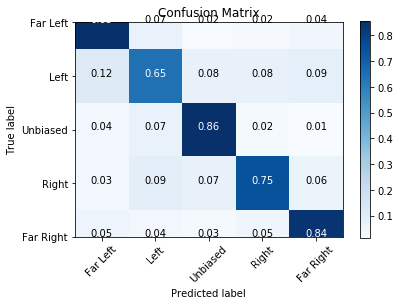

In [37]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


#Reads in data and cleans the text
df = pd.read_csv("Classifier_Data.csv")
df['Content'] = df['Content'].apply(clean_text)

#Splits data into training and testing
X = df['Content']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Data pipeline vectorizes, transforms and classifies the articles
data_pipeline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss = "modified_huber", random_state = 42, alpha = 1e-4, 
                                     class_weight="balanced", penalty = "elasticnet")),
              ])


data_pipeline.fit(X_train, y_train)
y_pred = data_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test, y_pred)
classes = ['Far Left', 'Left', 'Unbiased', "Right", "Far Right"]
plot_confusion_matrix(conf_mat, classes)